# To see interactive graphics open on https://nbviewer.jupyter.org/github/gabaslava/imdb/blob/master/23_Part_III_text_analysis.ipynb#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# III - Critic's reviews. Embedding

## Dataframe consisting of movie title, review, source of the review, and label
### There are 2763 samples

In [2]:
#opening the scraped critic's reviews:
df = pd.read_csv('title_review_outcome.csv')
df['review'] = df['review'].astype(str)
#eliminating 21 rows that have too few characters in the review column:
df = df[df['review'].apply(lambda x: len(x)>400)].reset_index()
df.head()

,index,title,source,review,outcome
0,0,Manchester by the Sea (2016),3brothers,"It’s hard to resist the stubborn, agonizing ch...",1
1,1,Eastern Promises (2007),3brothers,I remember Eastern Promises as a blunt physica...,0
2,2,'71 (2014),3brothers,Yann Demange’s ’71 is a rare contemporary exam...,1
3,3,A History of Violence (2005),3brothers,"At first glance, A History of Violence appears...",0
4,4,Dead Ringers (1988),3brothers,Dead Ringers is among the saddest and stranges...,1


In [3]:
len(df)

2763

In [6]:
reviews = list(df['review'].values)
outcome = list(df['outcome'].values)
info = df[['title', 'source']].values.tolist() 

stopwords = ['the', 'an', 'is' 'it', 'he', 'she', 'be', 'was']

tokenized_reviews=[]

for rev in reviews:
    t1 = rev.lower()
    t2 = re.sub(r"\\xa0", " ", t1) 
    t3 = re.sub(r"\\xad", "", t2)
    t4= word_tokenize(t3)
    t5 = [w for w in t4 if w.isalpha()] #remove all elements that are not alpahbetical
    t6 = [w for w in t5 if len(w)>1] #remove single letter words
    t0 = [w for w in t6 if w not in stopwords]
    tokenized_reviews.append(t0)

print(str(len(tokenized_reviews)) + ' reviews tokenized')

#getting rid of the the texts that have 300 words or less 
X=[]
Y=[]
G=[]

for i,e,f in zip(tokenized_reviews,outcome,info):
    if len(i)>300:
        X.append(i)
        Y.append(e)
        G.append(f)
        
print(str(len(tokenized_reviews)-len(X)) + ' reviews were removed as having too few words')

2763 reviews tokenized
80 reviews were removed as having too few words


### Cleaned sample now consists of 2683 reviews: 1353 categorized as Positive Sentiment and 1330 as Negative Sentiment

In [7]:
Counter(Y)

Counter({1: 1353, 0: 1330})

### Longest review now is 9075 words long, shortest - 302 words
### On average review has 812 words with standard deviation of 424
### Total word count(non unique) for all reviews combined is over 2.1M

In [67]:
max_len = max([len(i) for i in X]) #longest review(number of words)
min_len = min([len(i) for i in X]) #shortest review(number of words)
mean_x = np.mean([len(i) for i in X]) #average review
std_x = np.std([len(i) for i in X]) #stadard deviation
total_x = sum([len(i) for i in X]) #total word count/non-unique

max_len, min_len, round(mean_x,1), round(std_x,1), total_x

(9075, 302, 812.2, 424.5, 2179195)

# Converting strings of words into vectors with Word2Vec model.
### Vector dimentionality size will be 100, meaning each unique word will be represented with a vector of 100 numbers, using only the words taht appear in the whole corpora more than once(min_count=2). After the model was applied, it was discovered that there is 38,611 unique words(that appear more than once) in the corpora.

In [68]:
import gensim

model=gensim.models.Word2Vec(sentences=X, size=100, window=4, min_count=2) 
model.train(X, total_examples=len(X), epochs=2) 
unique_words=list(model.wv.vocab) 
len(unique_words)

38611

### Checking what words have similar vectorization to words 'politics', 'movie' and 'profound'
#### The meaning of words is in context of the critic reviews. Seems like words represented as vectors make more or less some sense

In [13]:
model.wv.most_similar('profound'), model.wv.most_similar('politics'), model.wv.most_similar('movie')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



([('philosophical', 0.8739913702011108),
  ('underlying', 0.8530736565589905),
  ('psychological', 0.8464193940162659),
  ('internal', 0.8413901925086975),
  ('inspiring', 0.8368321061134338),
  ('overt', 0.8348419666290283),
  ('authentic', 0.8282007575035095),
  ('delicate', 0.8260421752929688),
  ('realistic', 0.8251757025718689),
  ('thematic', 0.8192516565322876)],
 [('religion', 0.8141759634017944),
  ('economic', 0.7847653031349182),
  ('heroism', 0.7815650701522827),
  ('realities', 0.7803517580032349),
  ('observations', 0.779443085193634),
  ('ambiguity', 0.7711341381072998),
  ('greed', 0.7638932466506958),
  ('notions', 0.7576010227203369),
  ('concerns', 0.7560153007507324),
  ('mysteries', 0.7558717131614685)],
 [('film', 0.8956680297851562),
  ('picture', 0.7427400350570679),
  ('movies', 0.7362833023071289),
  ('films', 0.6766760349273682),
  ('thriller', 0.6333109140396118),
  ('genre', 0.6329866647720337),
  ('material', 0.6229885220527649),
  ('project', 0.6070940494

In [14]:
#saving the the word-vectors:
filename = 'gensimmodel_word2vec_TEST.csv'
model.wv.save_word2vec_format(filename, binary=False)

#creating a dictionary of words and their vectors
def word_and_vec(vectors_file):
    embeddings = {}
    f = open(vectors_file)
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector
    f.close()
    return embeddings

word_embeddings = word_and_vec('gensimmodel_word2vec_TEST.csv')

## Since the word2vec model was trained and embeddings are in place, corpus is cleaned once again: eliminating the uninformative words

In [178]:
#Eliminating unnecessary words from tokenized reviews:
X_cleaned = []
stopw = list(stop_words) + ['youve', 'youd', 'youll', 'theyd', 'theyve', 'theyre', 'shouldnt', 'theyll', 'werent', 'hadnt' , 'wouldnt', 'wasnt', 'ive', 'wouldve', 'youre', 'thatll', 'theyd', 'whos', 'whose', 'theres', 'heres', 'wheres']
Lem = WordNetLemmatizer()

for i in X:
    t1 = [w for w in i if w not in stopw]
    t2 = [w for w in t1 if len(w)>2]
    t0 = [Lem.lemmatize(w) for w in t2]
    X_cleaned.append(t0)

In [179]:
max_len_c = max([len(i) for i in X_cleaned]) #longest review(number of words)
min_len_c = min([len(i) for i in X_cleaned]) #shortest review(number of words)
mean_x_c = np.mean([len(i) for i in X_cleaned]) #average review
std_x_c = np.std([len(i) for i in X_cleaned]) #stadard deviation
total_x_c = sum([len(i) for i in X_cleaned]) #total word count/non-unique

max_len_c, min_len_c, round(mean_x_c,1), round(std_x_c,1), total_x_c

(5563, 177, 494.3, 256.7, 1326281)

### Separating words from positive sentiment reviews and negative sentiment word vectors.
### Those separated lists consist of 687,813 words that were in reviews labeled True and 638,468 words that were in reviews marked False

In [180]:
def separate_true_false_review_words(sentences, outcome):
    words_true = []
    words_false = []   
    for i,e in zip(sentences,outcome):
        if e==1:
            words_true+=i
        elif e==0:
            words_false+=i
    return words_true, words_false

words_true, words_false = separate_true_false_review_words(X_cleaned, Y)

#The length of 'true' and 'false' words sum up to total number of words in the corpora(total_x_c, cell 70)
len(words_true), len(words_false)  

(687813, 638468)

## Creating two dataframes of unique words and their count in each positive and negative sentiments
### Label 'True' has 37,466 unique words and 'False' has  36,748 unique words

In [181]:
true_unique =  pd.DataFrame.from_dict(Counter(words_true), orient='index').reset_index().sort_values(by=[0], ascending=False)
false_unique = pd.DataFrame.from_dict(Counter(words_false), orient='index').reset_index().sort_values(by=[0], ascending=False)

print('Positive sentiment corpus has a total of %d unique words, and %d of those appear more than once \nNegative sentiment corpus has a total of %d unique words and %d of those appear more than once.' % 
      (len(true_unique), len(true_unique.loc[true_unique[0]>1]), len(false_unique), len(false_unique.loc[false_unique[0]>1])))

Positive sentiment corpus has a total of 37466 unique words, and 24841 of those appear more than once 
Negative sentiment corpus has a total of 36748 unique words and 24282 of those appear more than once.


# Now vectorizing the words and creating a visual

In [89]:
def words_vectorized(words, embeddings, vec_dim, unique_word_emb):
    vectorized_words=np.zeros((len(words), vec_dim)) 
    for w,i in zip(words,range(len(words))):
        if w in unique_word_emb:
            vectorized_words[i] = embeddings[w]
    return vectorized_words

### Vectorizing the most common words in their explicit outcome. 
#### Extracting top 2000 words for each outcome and of those taking only the ones that are exclusively belonging to either one of the categories.
#### Each category has 295 words that are most common for their own outcome and at the same time not as common in the opposite outcome. Meaning that the remaining (85% of the words) are the same for both sentiments.

In [182]:
exp_true_in_top2000 = [i for i in list(true_unique[:2000]['index'].values) if i not in list(false_unique[:2000]['index'].values)]
exp_false_in_top2000 = [i for i in list(false_unique[:2000]['index'].values) if i not in list(true_unique[:2000]['index'].values)]

print('Both label True has %d words and label False has %d words in their Top2000 most frequent words that are explicitly attached to the label.' % 
      (len(exp_true_in_top2000), len(exp_false_in_top2000)))
print('\nTrue words repetition between: %d and %d times. \nFalse words repetition between: %d and %d times.' % 
     (max(true_unique[:2000][0]), min(true_unique[:2000][0]), max(false_unique[:2000][0]), min(false_unique[:2000][0])))


Both label True has 295 words and label False has 295 words in their Top2000 most frequent words that are explicitly attached to the label.

True words repetition between: 7402 and 63 times. 
False words repetition between: 6725 and 58 times.


In [183]:
#Vectorizing the words, using function from cell 89:
exp_true_vectors_top = words_vectorized(exp_true_in_top2000, word_embeddings, 100, unique_words)
exp_false_vectors_top = words_vectorized(exp_false_in_top2000, word_embeddings, 100, unique_words)

# Reducing dimentions with both PCA and tSNE and visualising the words from different outcomes

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [140]:
#Function for reduced dimention word representation
def represent_words(true_pca_tsne, false_pca_tsne, word_list_true, word_list_false):
    trace_true = go.Scatter(x = true_pca_tsne[:,0], y = true_pca_tsne[:,1], name = 'Positive Sentiment', mode = 'markers', marker = dict(size = 5,color = 'blue',opacity=0.6), text= word_list_true)
    trace_false = go.Scatter(x = false_pca_tsne[:,0], y = false_pca_tsne[:,1], name = 'Negative Sentiment', mode = 'markers', marker = dict(size = 5,color = 'red',opacity=0.5), text= word_list_false)
    layout = dict(title= 'Positive sentiment vs. Negative sentiment words', yaxis = dict(title='t-SNE 2'), xaxis = dict(title='t-SNE 1'), hovermode= 'closest')
    data = [trace_true, trace_false]
    fig = dict(data=data, layout=layout)
    py.iplot(fig)

## Applying Principal Component Analysis and t-distributed stochastic neighbor embedding and visualising the 2D vectors to find out if they form some kind of clusters
### From the graphs below it seems that both t-SNE and PCA reduced dimention vectors are intertwining greatly and clustering visible but not to an extent that was anticipated.

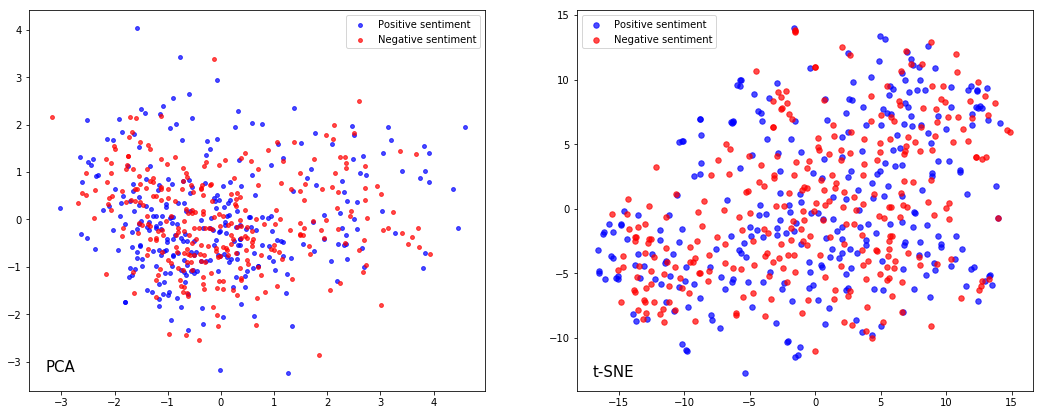

In [185]:
pca_top2000_exp = PCA(n_components=2).fit_transform(np.append(exp_true_vectors_top,exp_false_vectors_top, axis=0))
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=53)
tsne_top2000_exp = tsne.fit_transform(np.append(exp_true_vectors_top,exp_false_vectors_top, axis=0))

pca_top2000_exp_labeled = [[i,True] for i in pca_top2000_exp[:len(exp_true_vectors_top)]] + [[i,False] for i in pca_top2000_exp[len(exp_true_vectors_top):]]
tsne_top2000_exp_labeled = [[i,True] for i in tsne_top2000_exp[:len(exp_true_vectors_top)]] + [[i,False] for i in tsne_top2000_exp[len(exp_true_vectors_top):]]

fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for senentiment, label, color in zip(['Positive sentiment', 'Negative sentiment'], [True, False], ['b', 'r']):
    ax1.scatter([i[0][0] for i in pca_top2000_exp_labeled if i[1]==label], [i[0][1] for i in pca_top2000_exp_labeled if i[1]==label],
                s=15, marker="o", color=color, alpha=0.7, label=senentiment)
    ax2.scatter([i[0][0] for i in tsne_top2000_exp_labeled if i[1]==label], [i[0][1] for i in tsne_top2000_exp_labeled if i[1]==label],
                s=30, marker="o", color=color, alpha=0.7, label=senentiment)


ax1.legend()
ax1.text(-3.3, -3.2, 'PCA', fontsize=15)
ax2.legend()
ax2.text(-17, -13, 't-SNE', fontsize=15);

## Extracting the words for each outcome that are occuring between 63 and 21 times explicitly for the outcome.

In [186]:
exp_true_in_middle3000 = [i for i in list(true_unique[2000:5000]['index'].values) if i not in list(false_unique[2000:5000]['index'].values)]
exp_false_in_middle3000 = [i for i in list(false_unique[2000:5000]['index'].values) if i not in list(true_unique[2000:5000]['index'].values)]

print('Both label True has %d words and label False has %d words in their Middle3000 most frequent words that are explicitly attached to the label.' % 
      (len(exp_true_in_middle3000), len(exp_false_in_middle3000)))
print('\nTrue words repetition between: %d and %d times. \nFalse words repetition between: %d and %d times.' % 
     (max(true_unique[2000:5000][0]), min(true_unique[2000:5000][0]), max(false_unique[2000:5000][0]), min(false_unique[2000:5000][0])))

Both label True has 1096 words and label False has 1096 words in their Middle3000 most frequent words that are explicitly attached to the label.

True words repetition between: 63 and 22 times. 
False words repetition between: 58 and 21 times.


### Vectorizing the words and reducing dimentions for visualization:

In [187]:
exp_middle_true_vectors = words_vectorized(exp_true_in_middle3000, word_embeddings, 100, unique_words)
exp_middle_false_vectors = words_vectorized(exp_false_in_middle3000, word_embeddings, 100, unique_words)

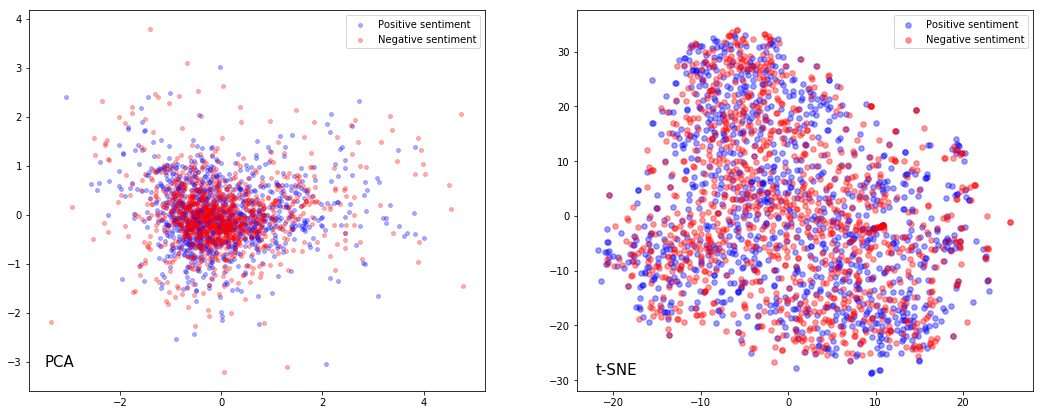

In [190]:
pca_middle_exp = PCA(n_components=2).fit_transform(np.append(exp_middle_true_vectors,exp_middle_false_vectors, axis=0))
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=53)
tsne_middle_exp = tsne.fit_transform(np.append(exp_middle_true_vectors,exp_middle_false_vectors, axis=0))

pca_middle_exp_labeled = [[i,True] for i in pca_middle_exp[:len(exp_middle_true_vectors)]] + [[i,False] for i in pca_middle_exp[len(exp_middle_true_vectors):]]
tsne_middle_exp_labeled = [[i,True] for i in tsne_middle_exp[:len(exp_middle_true_vectors)]] + [[i,False] for i in tsne_middle_exp[len(exp_middle_true_vectors):]]


fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for senentiment, label, color in zip(['Positive sentiment', 'Negative sentiment'], [True, False], ['b', 'r']):
    ax1.scatter([i[0][0] for i in pca_middle_exp_labeled if i[1]==label], [i[0][1] for i in pca_middle_exp_labeled if i[1]==label],
                s=15, marker="o", color=color, alpha=0.3, label=senentiment)
    ax2.scatter([i[0][0] for i in tsne_middle_exp_labeled if i[1]==label], [i[0][1] for i in tsne_middle_exp_labeled if i[1]==label],
                s=30, marker="o", color=color, alpha=0.4, label=senentiment)


ax1.legend()
ax1.text(-3.5, -3.1, 'PCA', fontsize=15)
ax2.legend()
ax2.text(-22, -29, 't-SNE', fontsize=15);

## Extracting the words for each outcome that are occuring between 22 and 8 times and are exclusive for the outcome.
### Each category has 2461 words that are specific for their own outcome and at the same time not belonging in the frequency group of the opposite outcome
#### This frequency category(words appearing between 22 and 8 times) share 49% of the words between sentiments, meaning less common words are more attached to the outcome.

In [193]:
exp_true_in_lessfrequent5000 = [i for i in list(true_unique[5000:10000]['index'].values) if i not in list(false_unique[5000:10000]['index'].values)]
exp_false_in_lessfrequent5000 = [i for i in list(false_unique[5000:10000]['index'].values) if i not in list(true_unique[5000:10000]['index'].values)]

print('Both label True has %d words and label False has %d words in their unique word list.' % 
      (len(exp_true_in_lessfrequent5000), len(exp_false_in_lessfrequent5000)))
print('\nTrue words repetition between: %d and %d times. \nFalse words repetition between: %d and %d times.' % 
     (max(true_unique[5000:10000][0]), min(true_unique[5000:10000][0]), max(false_unique[5000:10000][0]), min(false_unique[5000:10000][0])))

Both label True has 2461 words and label False has 2461 words in their unique word list.

True words repetition between: 22 and 8 times. 
False words repetition between: 21 and 8 times.


In [194]:
exp_lessfrequent_true_vectors = words_vectorized(exp_true_in_lessfrequent5000, word_embeddings, 100, unique_words)
exp_lessfrequent_false_vectors = words_vectorized(exp_false_in_lessfrequent5000, word_embeddings, 100, unique_words)

### Based on reduced dimention vectors, seems like this frequency category has more separation in regards of its word's meaning, clusters in t-SNE graph are more perceptible

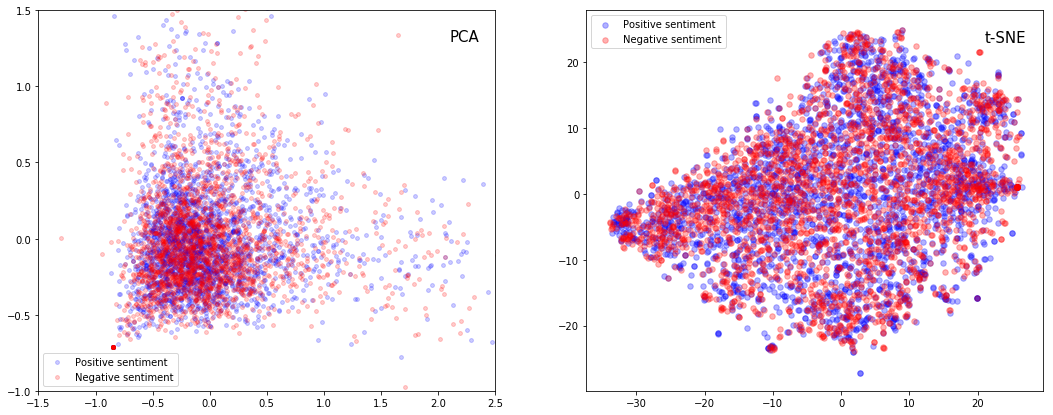

In [128]:
pca_lessfrequent_exp = PCA(n_components=2).fit_transform(np.append(exp_lessfrequent_true_vectors,exp_lessfrequent_false_vectors, axis=0))
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=53)
tsne_lessfrequent_exp = tsne.fit_transform(np.append(exp_lessfrequent_true_vectors,exp_lessfrequent_false_vectors, axis=0))

pca_lessfrequent_exp_labeled = [[i,True] for i in pca_lessfrequent_exp[:len(exp_lessfrequent_true_vectors)]] + [[i,False] for i in pca_lessfrequent_exp[len(exp_lessfrequent_true_vectors):]]
tsne_lessfrequent_exp_labeled = [[i,True] for i in tsne_lessfrequent_exp[:len(exp_lessfrequent_true_vectors)]] + [[i,False] for i in tsne_lessfrequent_exp[len(exp_lessfrequent_true_vectors):]]


fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for senentiment, label, color in zip(['Positive sentiment', 'Negative sentiment'], [True, False], ['b', 'r']):
    ax1.scatter([i[0][0] for i in pca_lessfrequent_exp_labeled if i[1]==label], [i[0][1] for i in pca_lessfrequent_exp_labeled if i[1]==label],
                s=15, marker="o", color=color, alpha=0.2, label=senentiment)
    ax2.scatter([i[0][0] for i in tsne_lessfrequent_exp_labeled if i[1]==label], [i[0][1] for i in tsne_lessfrequent_exp_labeled if i[1]==label],
                s=30, marker="o", color=color, alpha=0.3, label=senentiment)


ax1.legend()
ax1.set_xlim([-1.5,2.5])
ax1.set_ylim([-1,1.5])
ax1.text(2.1, 1.3, 'PCA', fontsize=15)
ax2.legend()
ax2.text(21, 23, 't-SNE', fontsize=15);

## Representing the words based on t-SNE:

In [142]:
represent_words(tsne_lessfrequent_exp[:len(exp_lessfrequent_true_vectors)], tsne_lessfrequent_exp[len(exp_lessfrequent_true_vectors):], exp_true_in_lessfrequent5000, exp_false_in_lessfrequent5000)

#### Appears that in the third quadrant of the plane, far on the left, mostly pleople names are represented. Words clustered in first quadrant around (23,13) are verbs, adjectives are around (3,12) coordinates.
### Unfortunately a great deal of words appearing very close in the graph do not actually carry a similar meaning

# Using GloVe pre-trained embedding
## GloVe is Stanford University pre-trained word embedding with a dictionary of 400K unique words. Pre-trained word vectors downloaded from: https://nlp.stanford.edu/projects/glove/

In [144]:
file = "glove.6B.50d.txt" #word embeddings - 50D vectors
def loadGloveModel(File):
    with open(File, encoding="utf8" ) as f:
        content = f.readlines()
    word_embeddings = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        word_embeddings[word] = embedding
    print (len(word_embeddings)," words loaded")
    return word_embeddings
     
glove_embedding = loadGloveModel(file)
glove_unique_words = list(glove_embedding.keys())


400000  words loaded


## Applying Principal Component Analysis and t-distributed stochastic neighbor embedding and visualising the 2D vectors on GloVe embedded words
### From the graphs below it seems that both t-SNE and PCA reduced dimention GloVe vectors are clustering more than in word2vec model

#### All the words are confirmed to be in the GloVe word dictionary

In [195]:
exp_true_in_top2000_glove = [i for i in exp_true_in_top2000 if i in glove_unique_words]
exp_false_in_top2000_glove = [i for i in exp_false_in_top2000 if i in glove_unique_words]
len(exp_true_in_top2000_glove), len(exp_false_in_top2000_glove)

(295, 295)

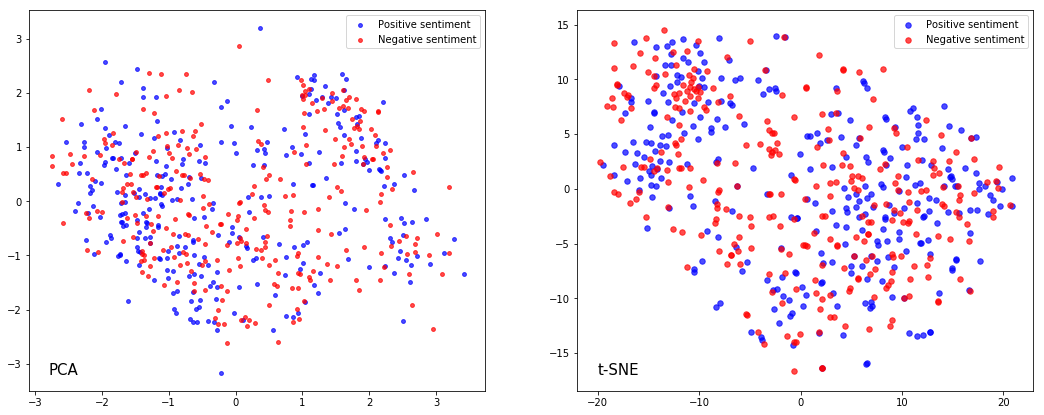

In [199]:
exp_true_glovevectors_top = words_vectorized(exp_true_in_top2000_glove, glove_embedding, 50, glove_unique_words)
exp_false_glovevectors_top = words_vectorized(exp_false_in_top2000_glove, glove_embedding, 50, glove_unique_words)

pca_glove_top2000_exp = PCA(n_components=2).fit_transform(np.append(exp_true_glovevectors_top,exp_false_glovevectors_top, axis=0))
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=53)
tsne_glove_top2000_exp = tsne.fit_transform(np.append(exp_true_glovevectors_top,exp_false_glovevectors_top, axis=0))

pca_glove_top2000_exp_labeled = [[i,True] for i in pca_glove_top2000_exp[:len(exp_true_in_top2000_glove)]] + [[i,False] for i in pca_glove_top2000_exp[len(exp_true_in_top2000_glove):]]
tsne_glove_top2000_exp_labeled = [[i,True] for i in tsne_glove_top2000_exp[:len(exp_true_in_top2000_glove)]] + [[i,False] for i in tsne_glove_top2000_exp[len(exp_true_in_top2000_glove):]]


fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for senentiment, label, color in zip(['Positive sentiment', 'Negative sentiment'], [True, False], ['b', 'r']):
    ax1.scatter([i[0][0] for i in pca_glove_top2000_exp_labeled if i[1]==label], [i[0][1] for i in pca_glove_top2000_exp_labeled if i[1]==label],
                s=15, marker="o", color=color, alpha=0.7, label=senentiment)
    ax2.scatter([i[0][0] for i in tsne_glove_top2000_exp_labeled if i[1]==label], [i[0][1] for i in tsne_glove_top2000_exp_labeled if i[1]==label],
                s=30, marker="o", color=color, alpha=0.7, label=senentiment)


ax1.legend()
ax1.text(-2.8, -3.2, 'PCA', fontsize=15)
ax2.legend()
ax2.text(-20, -17, 't-SNE', fontsize=15);

# Representing the words based on t-SNE:
### A big part of the words are names, they are clustered in second quadrant
### - around coordinates (-2.3, 5) words related to arts-music,dance,poetry are clustered
### - (11, 6) are gathered political theme words that all carry positive sentiment 
### - (12, -13) are gathered financial theme words that all labeled in positive sentiment 
### - (-6, -5) are gatheres sci-fi and fantasy related words that mainly carry negative sentiment

In [200]:
represent_words(tsne_glove_top2000_exp[:len(exp_true_glovevectors_top)], tsne_glove_top2000_exp[len(exp_true_glovevectors_top):], exp_true_in_top2000_glove, exp_false_in_top2000_glove)


## Vectorizing in GloVe and visualizing the words from middle frequency 
### Note that GloVe emeddings don't have all the words in it's dictionary, as a result from a total of 1096 sentiment exclusive words in the category 1085 'true' labeled will be vectorized and 1084 'false' labeled will be embedded

In [201]:
exp_true_in_middle_glove = [i for i in exp_true_in_middle3000 if i in glove_unique_words]
exp_false_in_middle_glove = [i for i in exp_false_in_middle3000 if i in glove_unique_words]
len(exp_true_in_middle_glove), len(exp_false_in_middle_glove)

(1085, 1084)

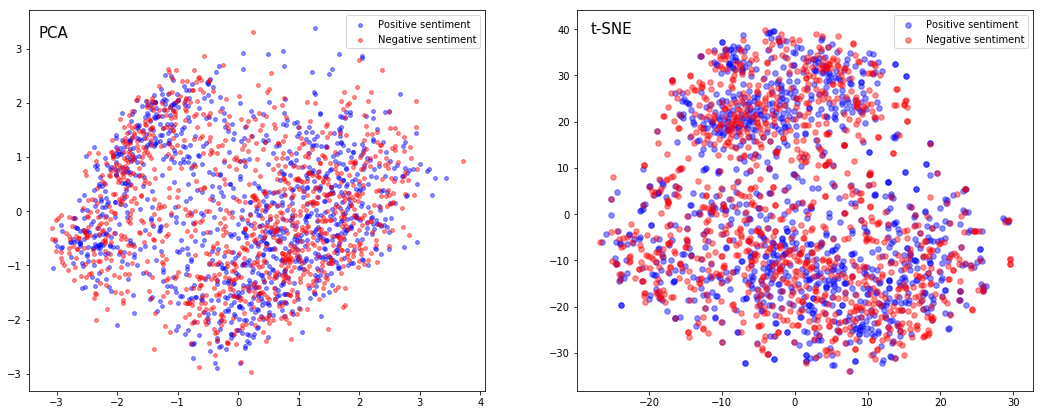

In [207]:
exp_middle_true_glovevectors = words_vectorized(exp_true_in_middle_glove, glove_embedding, 50, glove_unique_words)
exp_middle_false_glovevectors = words_vectorized(exp_false_in_middle_glove, glove_embedding, 50, glove_unique_words)

pca_glove_middle_exp = PCA(n_components=2).fit_transform(np.append(exp_middle_true_glovevectors,exp_middle_false_glovevectors, axis=0))
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=53)
tsne_glove_middle_exp = tsne.fit_transform(np.append(exp_middle_true_glovevectors,exp_middle_false_glovevectors, axis=0))

pca_glove_middle_exp_labeled = [[i,True] for i in pca_glove_middle_exp[:len(exp_middle_true_glovevectors)]] + [[i,False] for i in pca_glove_middle_exp[len(exp_middle_true_glovevectors):]]
tsne_glove_middle_exp_labeled = [[i,True] for i in tsne_glove_middle_exp[:len(exp_middle_true_glovevectors)]] + [[i,False] for i in tsne_glove_middle_exp[len(exp_middle_true_glovevectors):]]


fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for senentiment, label, color in zip(['Positive sentiment', 'Negative sentiment'], [True, False], ['b', 'r']):
    ax1.scatter([i[0][0] for i in pca_glove_middle_exp_labeled if i[1]==label], [i[0][1] for i in pca_glove_middle_exp_labeled if i[1]==label],
                s=15, marker="o", color=color, alpha=0.45, label=senentiment)
    ax2.scatter([i[0][0] for i in tsne_glove_middle_exp_labeled if i[1]==label], [i[0][1] for i in tsne_glove_middle_exp_labeled if i[1]==label],
                s=30, marker="o", color=color, alpha=0.45, label=senentiment)


ax1.legend()
ax1.text(-3.3, 3.2, 'PCA', fontsize=15)
ax2.legend()
ax2.text(-28, 39, 't-SNE', fontsize=15);

## Representing the words based on t-SNE:
#### Again on the upper side all the names are represented, first quadrant are movie names and director names, second quadrant are actor names
### Words in GloVe embedding are pictured more accurately, meaning words common in meaning stand closer together. Clustering is somewhat perceptible, at least more than in word2vec model, for example around coordinates (-18, -26) corporate and financial themed words are gathered and colored with negative sentiment color. On the other hand in the graph above(cell 200) those words are blue colored meaning that this theme is reoccuring both in Positive and Negative sentiment reviews but much higher occurence is on Positive sentiment

In [208]:
represent_words(tsne_glove_middle_exp[:len(exp_middle_true_glovevectors)], tsne_glove_middle_exp[len(exp_middle_true_glovevectors):], exp_true_in_middle_glove, exp_false_in_middle_glove)


## Visualising the words of low frequency that are uniquely attached to the outcome, vectorized with GloVe embedding
#### At this point over 60 words in each category are lost due to not being in GloVe embeddings dictionary

In [209]:
exp_true_in_lowfreq_glove = [i for i in exp_true_in_lessfrequent5000 if i in glove_unique_words]
exp_false_in_lowfreq_glove = [i for i in exp_false_in_lessfrequent5000 if i in glove_unique_words]
len(exp_true_in_lowfreq_glove), len(exp_false_in_lowfreq_glove)

(2390, 2393)

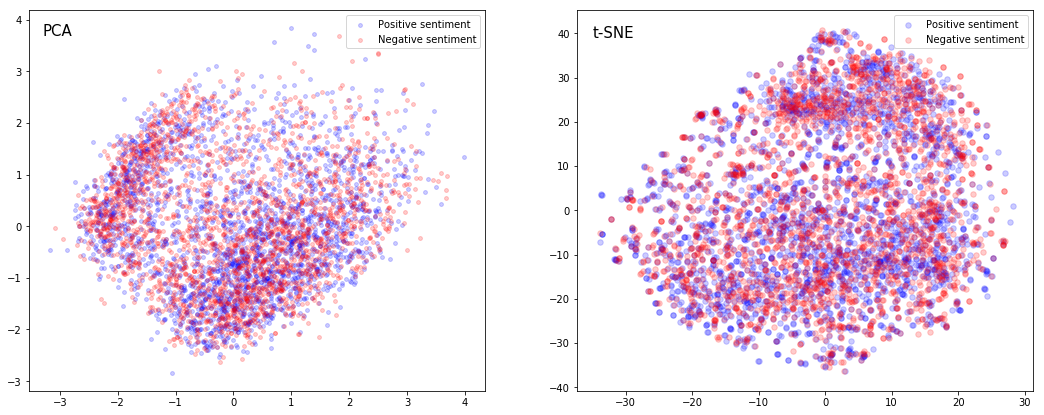

In [214]:
exp_lessfrequent_true_glove_vectors = words_vectorized(exp_true_in_lowfreq_glove, glove_embedding, 50, glove_unique_words)
exp_lessfrequent_false_glove_vectors = words_vectorized(exp_false_in_lowfreq_glove, glove_embedding, 50, glove_unique_words)

pca_lessfrequent_glove_exp = PCA(n_components=2).fit_transform(np.append(exp_lessfrequent_true_glove_vectors,exp_lessfrequent_false_glove_vectors, axis=0))
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=53)
tsne_lessfrequent_glove_exp = tsne.fit_transform(np.append(exp_lessfrequent_true_glove_vectors,exp_lessfrequent_false_glove_vectors, axis=0))

pca_lessfrequent_glove_exp_labeled = [[i,True] for i in pca_lessfrequent_glove_exp[:len(exp_lessfrequent_true_glove_vectors)]] + [[i,False] for i in pca_lessfrequent_glove_exp[len(exp_lessfrequent_true_glove_vectors):]]
tsne_lessfrequent_glove_exp_labeled = [[i,True] for i in tsne_lessfrequent_glove_exp[:len(exp_lessfrequent_true_glove_vectors)]] + [[i,False] for i in tsne_lessfrequent_glove_exp[len(exp_lessfrequent_true_glove_vectors):]]


fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for senentiment, label, color in zip(['Positive sentiment', 'Negative sentiment'], [True, False], ['b', 'r']):
    ax1.scatter([i[0][0] for i in pca_lessfrequent_glove_exp_labeled if i[1]==label], [i[0][1] for i in pca_lessfrequent_glove_exp_labeled if i[1]==label],
                s=15, marker="o", color=color, alpha=0.2, label=senentiment)
    ax2.scatter([i[0][0] for i in tsne_lessfrequent_glove_exp_labeled if i[1]==label], [i[0][1] for i in tsne_lessfrequent_glove_exp_labeled if i[1]==label],
                s=30, marker="o", color=color, alpha=0.2, label=senentiment)


ax1.legend()
ax1.text(-3.3, 3.7, 'PCA', fontsize=15)
ax2.legend()
ax2.text(-35, 39, 't-SNE', fontsize=15);

## Representing the words based on t-SNE:

In [211]:
represent_words(tsne_lessfrequent_glove_exp[:len(exp_lessfrequent_true_glove_vectors)], tsne_lessfrequent_glove_exp[len(exp_lessfrequent_true_glove_vectors):], exp_true_in_lowfreq_glove, exp_false_in_lowfreq_glove)
